<a href="https://colab.research.google.com/github/gauriverma19/NYC_AIRBNB_PRICE_PREDICTION/blob/master/airbnb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
data = pd.read_csv('AB_NYC_2019.csv/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [18]:
print('Number of features: {}'.format(data.shape[1]))
print('Number of examples: {}'.format(data.shape[0]))

Number of features: 16
Number of examples: 48895


In [19]:
#for c in df.columns:
#    print(c, dtype(df_train[c]))
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [20]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

preprocessing and eda

handling missing data

In [21]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
reviews_per_month,10052,0.205583
last_review,10052,0.205583
host_name,21,0.000429
name,16,0.000327
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000
minimum_nights,0,0.000000
price,0,0.000000
room_type,0,0.000000


In [22]:
data.drop(['host_name','name'], axis=1, inplace=True)

In [23]:
data[data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place.

For reviews_per_month, I will fill those values with 0's.

In [24]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [25]:
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [26]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


Price Distribution

1. I notice that the target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


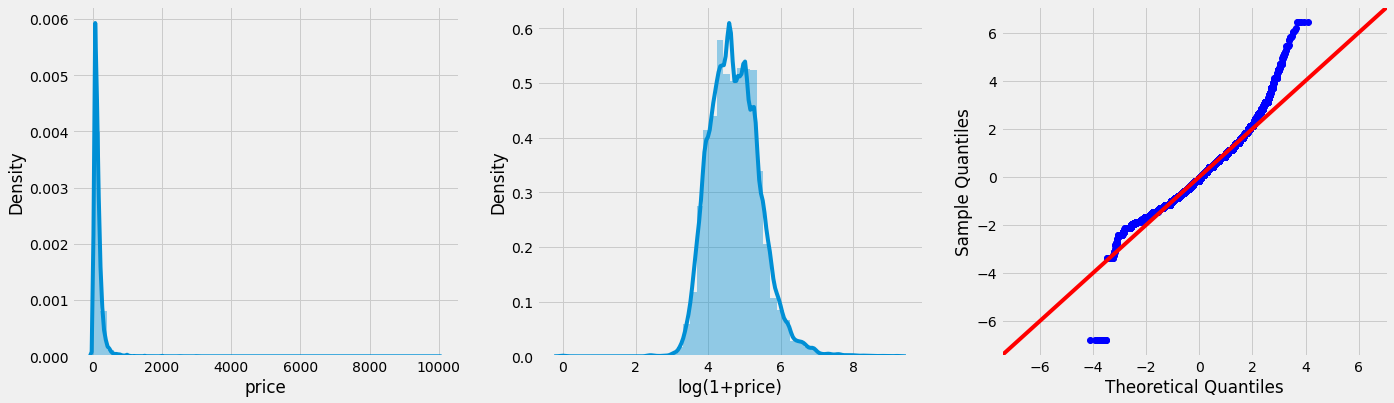

In [27]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [28]:
data = data[np.log1p(data['price']) < 8]
data = data[np.log1p(data['price']) > 3]

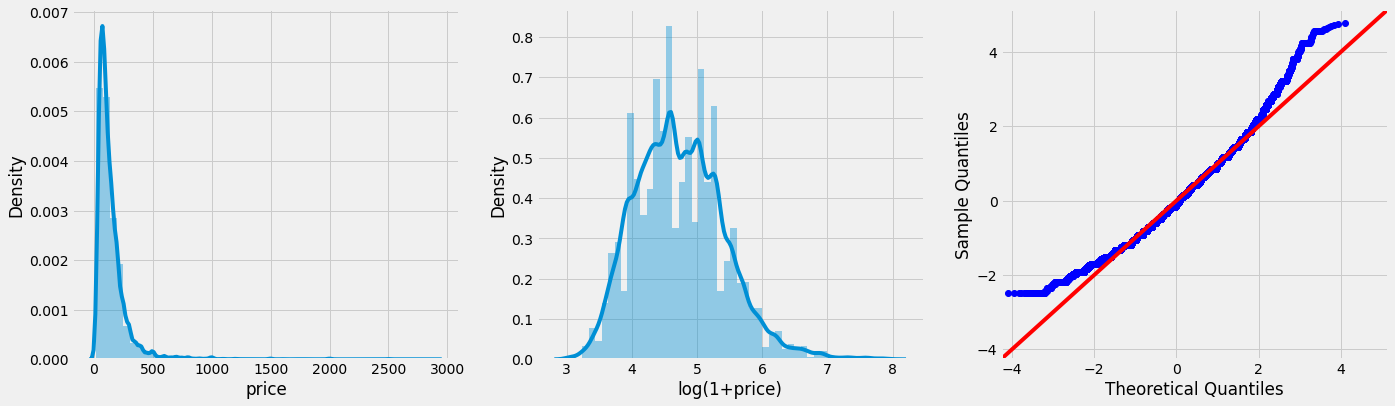

In [29]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['price'], ax=axes[0])
sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [30]:
data['price'] = np.log1p(data['price'])

A list of predictors

In [31]:
print(data.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [32]:
print('In this dataset there are {} unique hosts renting out  a total number of {} properties.'.format(len(data['host_id'].unique()), data.shape[0]))

In this dataset there are 37384 unique hosts renting out  a total number of 48784 properties.


In [33]:
data = data.drop(['host_id', 'id'], axis=1)

Neihbourhood Group Analysis

I notice that Statten Island and the Bronx are highly underrepresented in this dataset. For Statten Island, the reason is that the population of the island is small. However, this can't be the case for the Bronx which has a population comparable (~1.4mln) to Manhattan (~1.6mln) or for for Brooklyn /Queens with their populations of ~2.5mln and ~2.4mln, respectively. 

This makes sense: Queens, the Bronx  and, to a fair extent Brooklyn, are residential neighborhoods unlike Manhattan which is a business centre as well as a tourist destination.

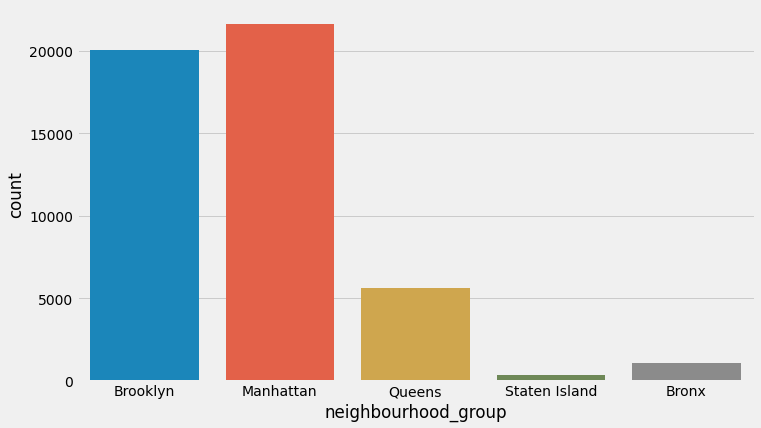

In [34]:
sns.catplot(x='neighbourhood_group', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(12, 6)

Longitude and Latitude

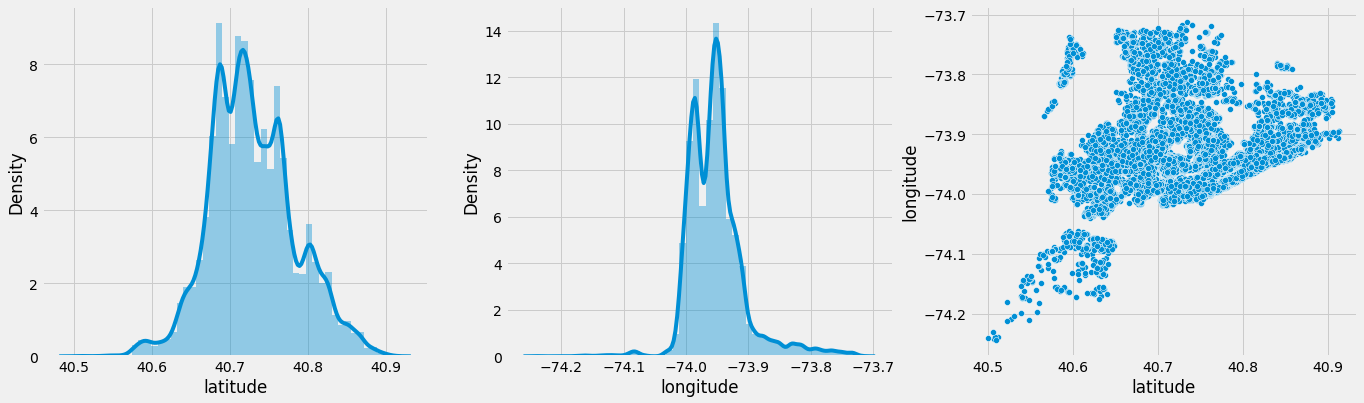

In [35]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'])

Room Type


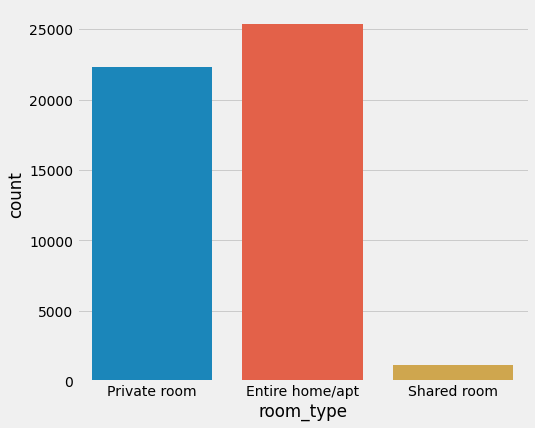

In [36]:
sns.catplot(x='room_type', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(8, 6)

Minimum Nights

Text(0, 0.5, 'count')

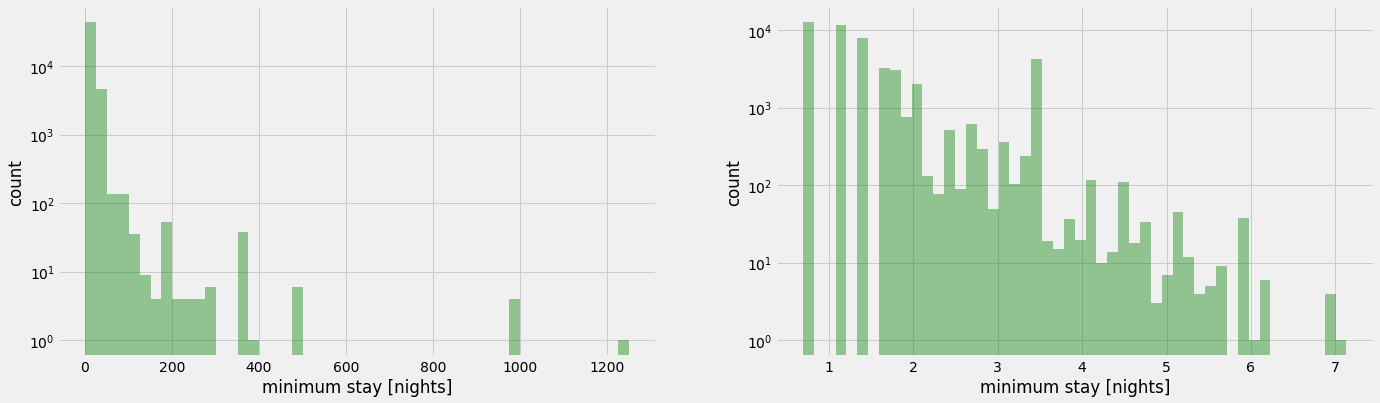

In [37]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count')

In [38]:
data['minimum_nights'] = np.log1p(data['minimum_nights'])

Reviews per month

Text(0.5, 0, 'ln(reviews_per_month)')

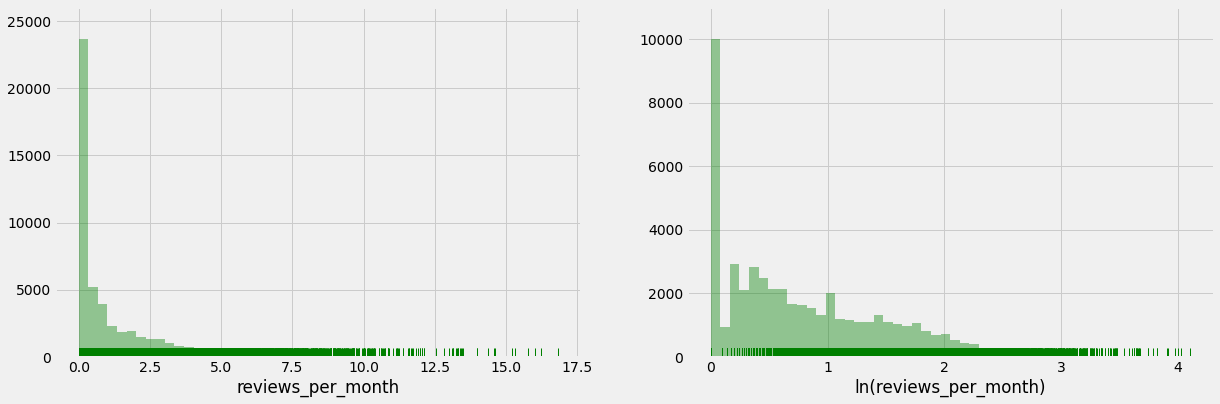

In [39]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))
sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])
sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)')

The distribution of the number of reviews per month is highly skewed however way we cut it. This is because there is a large weight on small numbers: there are a lot of properties which only get a few reviews and a rather fat tail of properties which get a lot of reviews. 

One explanation would be that the properties which are available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

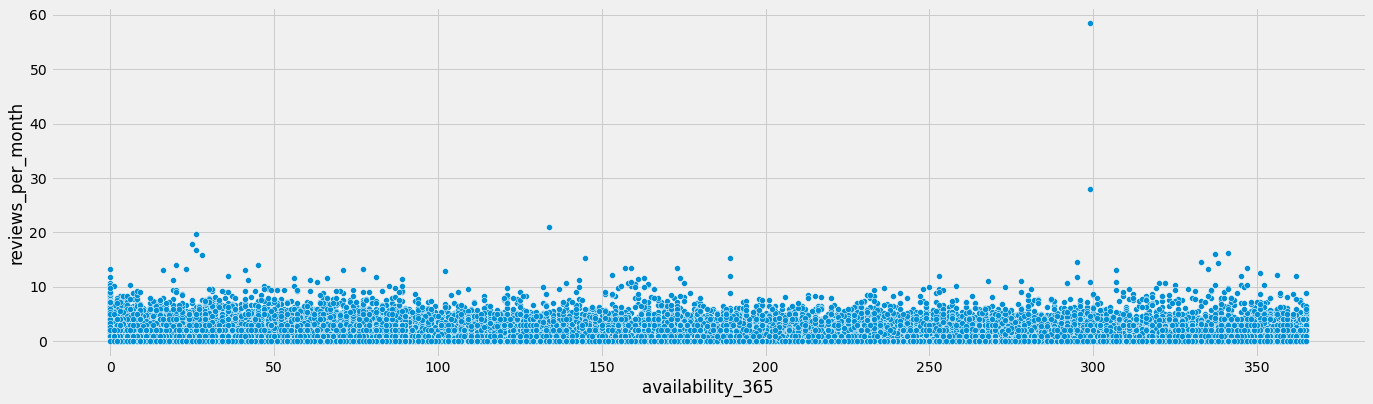

In [40]:
fig, axes = plt.subplots(1,1, figsize=(21,6))
sns.scatterplot(x= data['availability_365'], y=data['reviews_per_month'])

In [41]:
data['reviews_per_month'] = data[data['reviews_per_month'] < 17.5]['reviews_per_month']

availability

(0.0, 365.0)

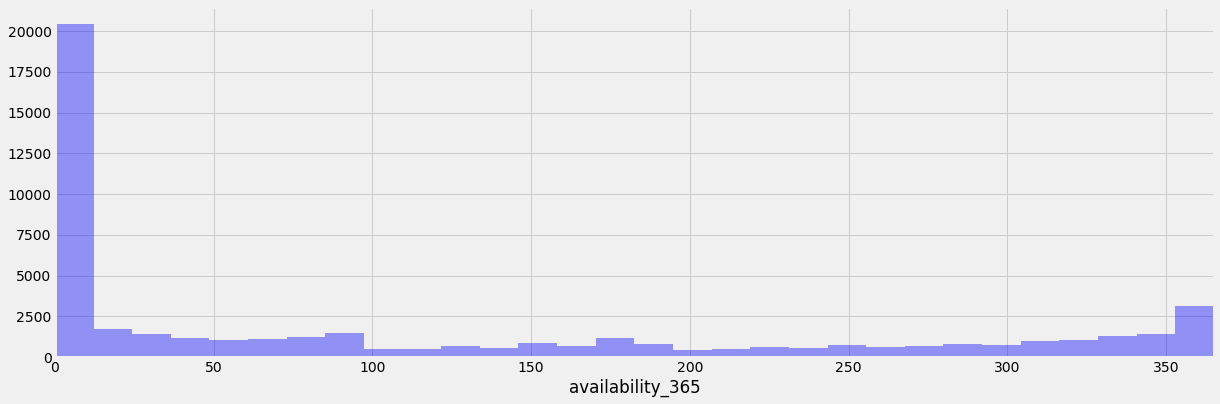

In [43]:
fig, axes = plt.subplots(1,1,figsize=(18.5, 6))
sns.distplot(data['availability_365'], rug=False, kde=False, color="blue", ax=axes)
axes.set_xlabel('availability_365')
axes.set_xlim(0, 365)

feature engineering

In [44]:
data['all_year_avail'] = data['availability_365']>353
data['low_avail'] = data['availability_365']< 12
data['no_reviews'] = data['reviews_per_month']==0

pearson correlation

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


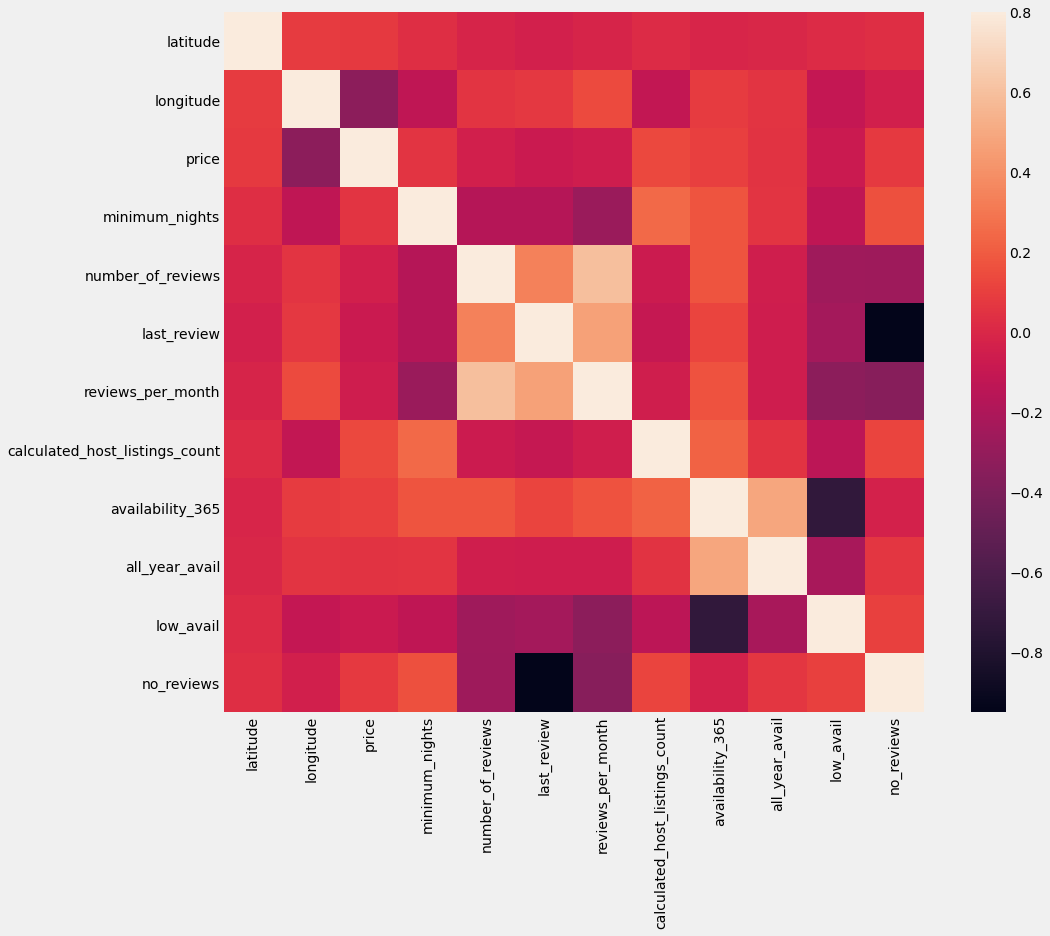

In [45]:
corrmatrix = data.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)


There don't appear to exist obvious, strong correlations between these variables.

However, the number of reviews per month is fairly (40%) correlated with the total number of reviews and the the total number of reviews is correlated (at 30%) with the availability of the property. Both of these correlations make sense.

It's also interesting that the longitude is anticorrelated (at 20%) with the price. That also makes sense - property in the Bronx and in Queens is cheaper than Manhattan and Brooklyn.




Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.


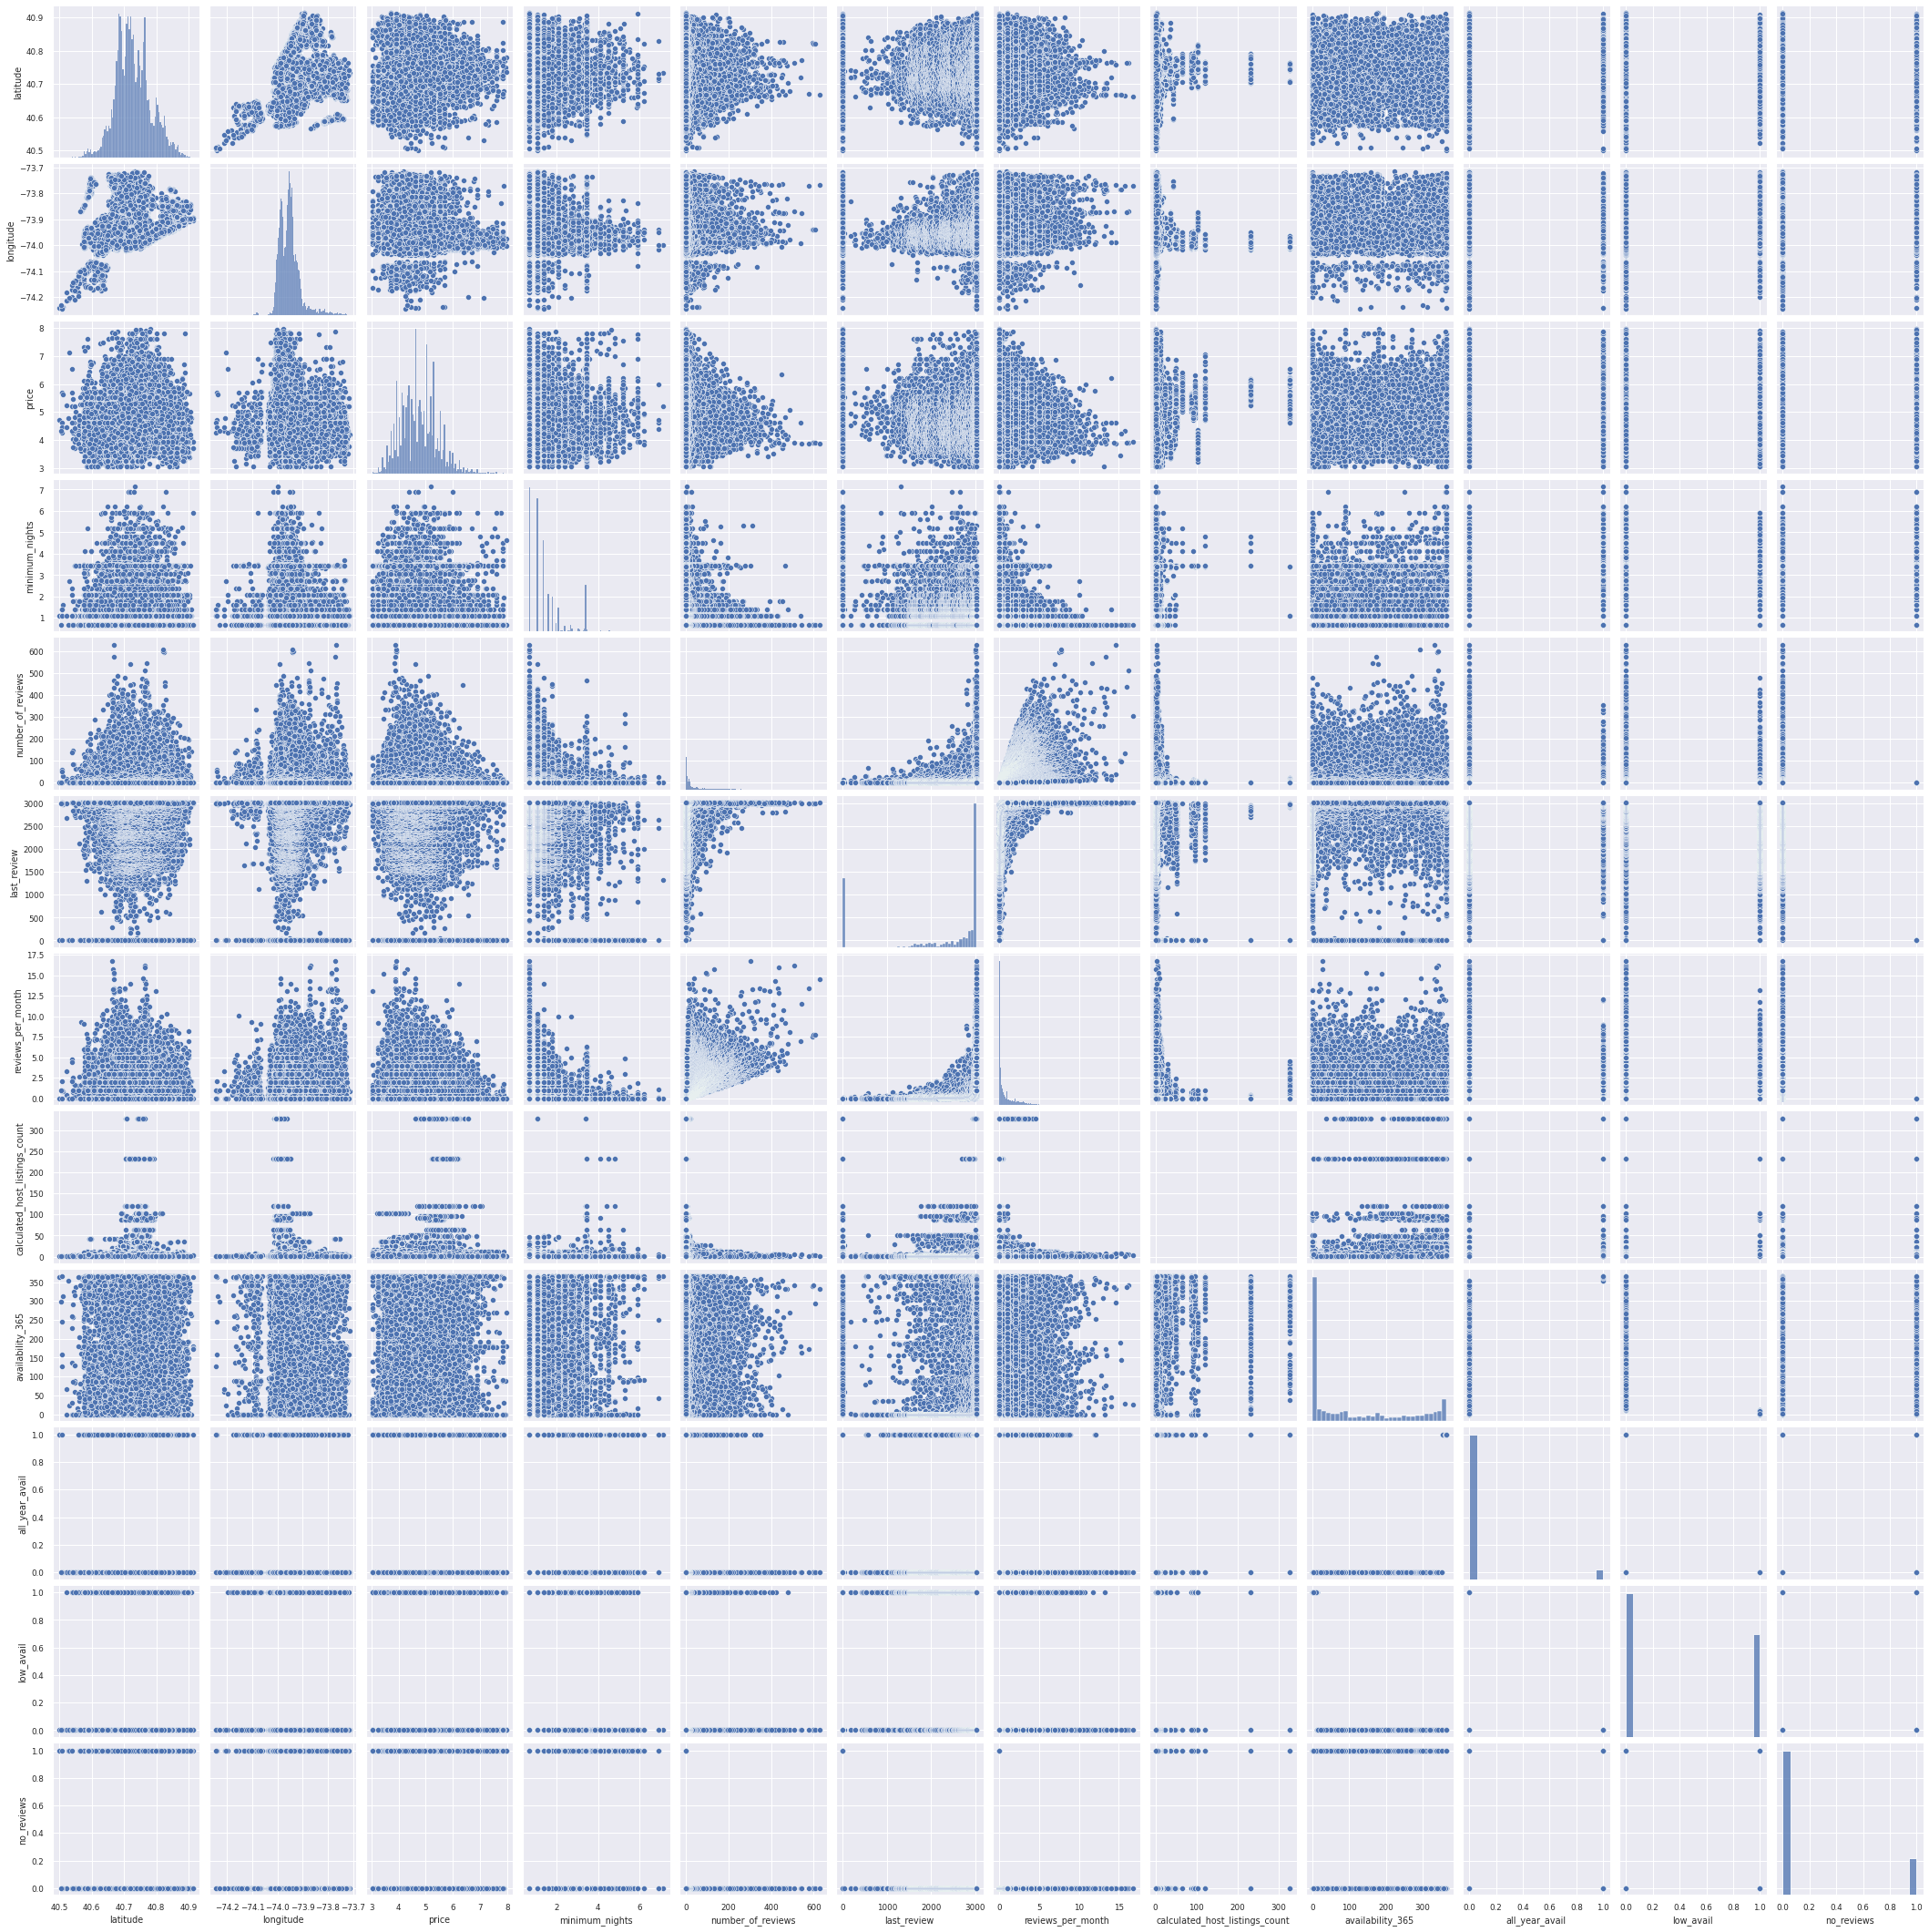

In [46]:
#pair plot
sns.pairplot(data.select_dtypes(exclude=['object']))

encoding categorical features

In [47]:
categorical_features = data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

Categorical features: (48784, 3)


In [48]:
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [49]:
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [50]:
#save transformed dataframe for future use

numerical_features =  data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))

Numerical features: (48784, 11)


In [51]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
#print('Dimensions of the design matrix: {}'.format(X.shape))
#print('Dimension of the target vector: {}'.format(y.shape))

In [52]:
processed_data = pd.concat([X_df, y], axis = 1)
processed_data.to_csv('NYC_Airbnb_processed.dat')

Test - Train Split


I'm going to split the data into a test set and a training set. I will hold out the test set until the very end and use the error on those data as an unbiased estimate of how my models did.

I might perform a further split later on the training set into training set proper and a validation set or I might cross-validate.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (39027, 240)
Dimensions of the training target vector: (39027,)
Dimensions of the test feature matrix: (9757, 240)
Dimensions of the test target vector: (9757,)


Rescale the design matrix

I now scale the design matrix with sklearn's RobustScaler() so that each predictor has zero mean and unit variance. This helps the convergence of machine learning algorithms such as linear regression.

I avoid data snooping by defining the scaleing transformation based on the training data not the test data.

In [55]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)